<a href="https://colab.research.google.com/github/hager2164/DL_tasks/blob/main/CIFAR10_With_AlexNet_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as trans
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
device = torch.device("cuda"if torch.cuda.is_available() else "cpu")

In [3]:
batchSize = 64


In [4]:
def get_train_valid_loader (data_dir , batch_size , augment , random_seed , valid_size =0.1 , shuffle = True ):
  normalize = trans .Normalize (
         mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010],
  )
  valid_transform = trans.Compose ([
      trans.Resize((227,227)),
            trans.ToTensor(),
            normalize,
  ])

  if augment :
    train_transform = trans.Compose([trans.RandomCrop(32 , padding =4 ) ,
                                     trans . RandomHorizontalFlip(),
                                     trans.ToTensor (),
                                     normalize ,])
  else:
    train_transform = trans.Compose([trans.Resize((227 , 227)),
                                     trans.ToTensor (),
                                     normalize ,])
  train_dataset = torchvision.datasets.CIFAR10(root = data_dir , train = True , download = True , transform = train_transform)
  valid_dataset = torchvision.datasets.CIFAR10(root = data_dir , train = True , download = True , transform = valid_transform  )
  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))
  if shuffle :
      np.random.seed(random_seed)
      np.random.shuffle(indices)
      train_idx , valid_idx = indices[split:] , indices[:split]
      train_sampler = SubsetRandomSampler(train_idx)
      valid_sampler = SubsetRandomSampler(valid_idx)
      train_loader = torch.utils.data.DataLoader(train_dataset , batch_size = batch_size ,
                                             sampler = valid_sampler)
      valid_loader = torch.utils.data.DataLoader(valid_dataset , batch_size = batch_size ,
                                             sampler = valid_sampler)

  return (train_loader ,  valid_loader )

In [5]:
def get_test_loader (data_dir , batch_size , shuffle =True) :
   normalize = trans.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
   transform = trans.Compose ([
      trans.Resize((227,227)),
            trans.ToTensor(),
            normalize,
  ])
   dataset = torchvision.datasets. CIFAR10(root = data_dir , train=False ,
                                           download= True , transform=transform)
   Data_loader= torch.utils.data.DataLoader(
       dataset , batch_size = batch_size , shuffle = shuffle
   )
   return Data_loader

In [6]:
train_loader, valid_loader = get_train_valid_loader(data_dir = './Cifar10', batch_size = batchSize, augment = False,random_seed = 1)


100%|██████████| 170M/170M [00:03<00:00, 49.0MB/s]


In [7]:
test_loader = get_test_loader(data_dir = './Cifar10', batch_size = batchSize)

In [8]:
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [10]:
dataiter = iter(train_loader)
images ,labels = next(dataiter)

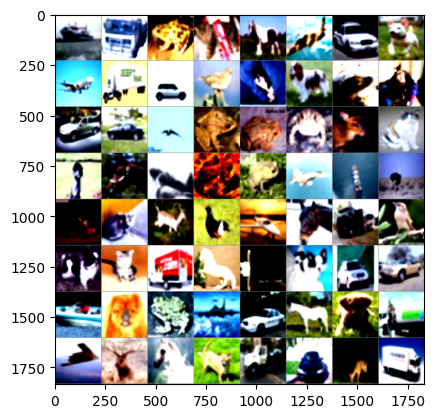

In [11]:
imshow(torchvision.utils.make_grid(images))

In [12]:
class AlexNet(nn.Module):
  def __init__ (self , num_classes =10 ):
    super(AlexNet,self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3 ,96 , kernel_size =11 , stride =4 , padding =0),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =3 , stride =2)  )

    self .layer2 = nn.Sequential(
        nn.Conv2d(96 ,256 , kernel_size =5 , stride =1 , padding =2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size =3 , stride =2)  )

    # Following standard AlexNet architecture after the first pooling layer
    self .layer3 = nn.Sequential(
        nn.Conv2d(256 , 384 ,kernel_size= 3 , stride =1 , padding =1), # Expects 256 in_channels, outputs 384
        nn.BatchNorm2d(384),
        nn.ReLU()  )
    self .layer4 = nn.Sequential(
        nn.Conv2d(384, 384 ,kernel_size= 3 , stride =1 , padding =1), # Expects 384 in_channels, outputs 384
        nn.BatchNorm2d(384),
        nn.ReLU()  )
    self .layer5 = nn.Sequential( # Corrected from self.layer3 typo
        nn.Conv2d(384, 256 ,kernel_size= 3 , stride =1 , padding =1), # Expects 384 in_channels, outputs 256
        nn.BatchNorm2d(256),
        nn.ReLU() ,
        nn.MaxPool2d(kernel_size =3 , stride =2)
         )
    # Calculate the input features for the first fully connected layer
    # This depends on the output size of layer5 after max pooling
    # With input size 227x227 and the given layers/pooling, the output spatial size after layer5 is 6x6
    self.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(256 * 6 * 6 , 4096), # 256 channels * 6 * 6 spatial size
        nn.ReLU()
    )
    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(4096 , 4096),
        nn.ReLU()
    )
    self.fc2= nn.Sequential(
        nn.Linear(4096 , num_classes)
    )
  def forward (self ,x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

In [13]:
num_classes = 10
num_epochs = 20
batch_size = 64
learning_rate = 0.005

In [14]:
model = AlexNet(num_classes).to(device)

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate , weight_decay =0.005 , momentum =0.9)

In [16]:
total = len(train_loader)

In [17]:
for epoch in range (num_epochs ):
  for i ,(images ,labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    loss = criterion(outputs , labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total}], Loss: {loss.item():.4f}')

  with torch.no_grad():
    correct =0
    T =0
    for images , labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data , 1)
      T += labels.size(0)
      correct += (predicted == labels).sum().item()
      del images , labels , outputs
    print("accuracy" , 5000 , 100*correct/total )

Epoch [1/20], Step [1/79], Loss: 2.3039
Epoch [1/20], Step [2/79], Loss: 2.3321
Epoch [1/20], Step [3/79], Loss: 2.3619
Epoch [1/20], Step [4/79], Loss: 2.3295
Epoch [1/20], Step [5/79], Loss: 2.2827
Epoch [1/20], Step [6/79], Loss: 2.3723
Epoch [1/20], Step [7/79], Loss: 2.3794
Epoch [1/20], Step [8/79], Loss: 2.2308
Epoch [1/20], Step [9/79], Loss: 2.3453
Epoch [1/20], Step [10/79], Loss: 2.3131
Epoch [1/20], Step [11/79], Loss: 2.2642
Epoch [1/20], Step [12/79], Loss: 2.2724
Epoch [1/20], Step [13/79], Loss: 2.1973
Epoch [1/20], Step [14/79], Loss: 2.1911
Epoch [1/20], Step [15/79], Loss: 2.2504
Epoch [1/20], Step [16/79], Loss: 2.2377
Epoch [1/20], Step [17/79], Loss: 2.1802
Epoch [1/20], Step [18/79], Loss: 2.1330
Epoch [1/20], Step [19/79], Loss: 2.0415
Epoch [1/20], Step [20/79], Loss: 2.2876
Epoch [1/20], Step [21/79], Loss: 1.9813
Epoch [1/20], Step [22/79], Loss: 1.9468
Epoch [1/20], Step [23/79], Loss: 2.1846
Epoch [1/20], Step [24/79], Loss: 2.0694
Epoch [1/20], Step [25/79

In [18]:
with torch.no_grad():
    correct =0
    T =0
    for images , labels in test_loader:
      images = images.to(device)
      labels = labels.to(device)
      outputs = model(images)
      _, predicted = torch.max(outputs.data , 1)
      T += labels.size(0)
      correct += (predicted == labels).sum().item()
      del images , labels , outputs
    print("accuracy" , 10000 , 100*correct/total )

accuracy 10000 7964.556962025316


In [20]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

In [21]:
for i in range(10):
  print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 68 %
Accuracy of   car : 84 %
Accuracy of  bird : 43 %
Accuracy of   cat : 34 %
Accuracy of  deer : 61 %
Accuracy of   dog : 58 %
Accuracy of  frog : 75 %
Accuracy of horse : 56 %
Accuracy of  ship : 68 %
Accuracy of truck : 81 %
